<a href="https://colab.research.google.com/github/bijitdeb/Course/blob/master/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying Entities in Healthcare Data

In [8]:
#give google drive permission
import pathlib
import os
from google.colab import drive
drive.mount('/content/gdrive')
base_dir = pathlib.Path('/content/gdrive/My Drive/NER_Medical_Data')
os.chdir(str(base_dir))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Workspace set up: Import and Install useful packages.

In [37]:
!pip install pycrf
!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import pandas as pd

model = spacy.load("en_core_web_sm")

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line.
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

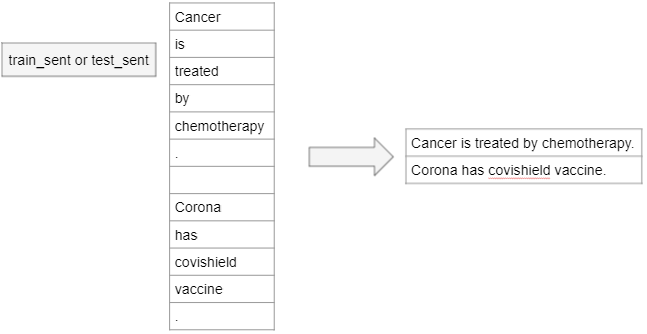

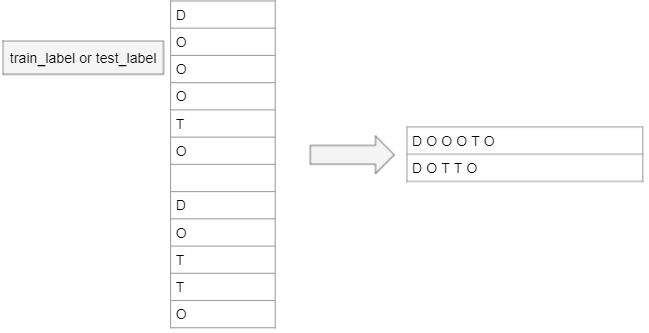

In [9]:
# Reading the train sentences and labels
with open('train_sent', 'r', encoding="utf-8") as train_sent_file:
  train_words = train_sent_file.readlines()
  train_sent_file.close()

with open('train_label', 'r') as train_labels_file:
  train_labels = train_labels_file.readlines()
  train_labels_file.close()

# Reading the test sentences and labels
with open('test_sent', 'r') as test_sent_file:
  test_words = test_sent_file.readlines()
  test_sent_file.close()

with open('test_label', 'r') as test_labels_file:
  test_labels = test_labels_file.readlines()
  test_labels_file.close()

In [10]:
# Check to see whether the number of words and no. of corresponding labels match.
print("Count of tokens in training set\n","No. of words: ",len(train_words),"\nNo. of labels: ",len(train_labels))
print("\n\nCount of tokens in test set\n","No. of words: ",len(test_words),"\nNo. of labels: ",len(test_labels))

Count of tokens in training set
 No. of words:  48501 
No. of labels:  48501


Count of tokens in test set
 No. of words:  19674 
No. of labels:  19674


In [11]:
# Function to combine words belonging to the same sentence. Sentences are separated by "\n" in the dataset.
def convert_to_sentences(dataset):
    sent_list = []
    sent = ""
    for entity in dataset:
        if entity != '\n':
            sent = sent + entity[:-1] + " "       # Adding word/label to current sentence / sequence of labels
        else:
            sent_list.append(sent[:-1])           # Getting rid of the space added after the last entity.
            sent = ""
    return sent_list

In [12]:
# Converting tokens to sentences and individual labels to sequences of corresponding labels.
train_sentences = convert_to_sentences(train_words)
train_labels = convert_to_sentences(train_labels)
test_sentences = convert_to_sentences(test_words)
test_labels = convert_to_sentences(test_labels)

In [13]:
print("First five training sentences and their labels:\n")
for i in range(5):
    print(train_sentences[i],"\n",train_labels[i],"\n")

First five training sentences and their labels:

All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status ) 
 O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 ) 
 O O O O O O O O O O O O O O O O O O O O O O O O O 

Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 ) 
 O O O O O O O O O O O O O O O 

The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 ) 
 O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 

Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 a

In [14]:
print("First five test sentences and their labels:\n")
for i in range(5):
    print(test_sentences[i],"\n",test_labels[i],"\n")

First five test sentences and their labels:

Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 ) 
 O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 

As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration 
 O O O O O O O O O O O O O O O O O O O 

The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period 
 O O O O O O O O O O O O O O O O O O O O O O O O 

There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 ) 
 O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 

Fluctuations in ambient temperature are inversely correlated to ch

### Count the number of sentences in the processed train and test dataset

In [15]:
print("Number of sentences in the train dataset: {}".format(len(train_sentences)))
print("Number of sentences in the test dataset: {}".format(len(test_sentences)))

Number of sentences in the train dataset: 2599
Number of sentences in the test dataset: 1056


### Count the number of lines of labels in the processed train and test dataset.

In [16]:
print("Number of lines of labels in the train dataset: {}".format(len(train_labels)))
print("Number of lines of labels in the test dataset: {}".format(len(test_labels)))

Number of lines of labels in the train dataset: 2599
Number of lines of labels in the test dataset: 1056


##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging.



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [17]:
# Creating a combined dataset from training and test sentences, since this is an Exploratory analysis.
combined = train_sentences + test_sentences
print("Number of sentences in combined dataset (training + test): {}".format(len(combined)))

# Creating a list of tokens which have PoS tag of 'NOUN' or 'PROPN'
noun_propn = []         # Initiating list for nouns and proper nouns
pos_tag = []            # initiating list for corresponding PoS tags.
for sent in combined:
    for token in model(sent):
        if token.pos_ in ['NOUN', 'PROPN']:
           noun_propn.append(token.text)
           pos_tag.append(token.pos_)
print("No. of tokens in combined dataset with PoS tag of 'NOUN' or 'PROPN': {}".format(len(noun_propn)))

print(len(pos_tag))

Number of sentences in combined dataset (training + test): 3655
No. of tokens in combined dataset with PoS tag of 'NOUN' or 'PROPN': 24373
24373


### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [18]:
noun_pos = pd.DataFrame({"NOUN_PROPN":noun_propn,"POS_tag":pos_tag})
print("Top 25 comon tokens with PoS tag of 'NOUN' or 'PROPN' \n")
print(noun_pos["NOUN_PROPN"].value_counts().head(25))

Top 25 comon tokens with PoS tag of 'NOUN' or 'PROPN' 

patients        492
treatment       281
%               247
cancer          200
therapy         175
study           154
disease         142
cell            140
lung            116
group            94
chemotherapy     88
gene             87
effects          85
results          79
women            77
use              74
TO_SEE           74
risk             71
surgery          71
cases            71
analysis         70
rate             67
response         66
survival         65
children         64
Name: NOUN_PROPN, dtype: int64


## Defining features for CRF





In [19]:
# Let's define the features to get the feature value for one word.
# Analysis of PoS tags - Independent assignment for words vs Contextual assignment in a sentence.
sentence = train_sentences[1]
sent_list = sentence.split()      # Splitting the sentence into its constituent words.
position = 2                      # Choosing position of word within sentence. Index starts at 0.

word = sent_list[position]        # Extracting word for PoS tag analysis.

print(sentence)

# Independent assignment of PoS tag (No contextual info)
print("\nPoS tag of word in isolation\nWord:",word,"--",model(word)[0].pos_,"\n")

# Contextual assignment of PoS tag based on other words in the sentence.
print("PoS tag of all words in sentence with context in tact.")
for token in model(sentence):
    print(token.text, "--", token.pos_)

# Modified workflow to obtain PoS tag of specific word in question while keeping sentence context in tact.
print("\nResult of modified workflow to obtain PoS tag of word at a specific position while keeping context within sentence in-tact.")
cnt = 0                           # Count of the word position within sentence.
for token in model(sentence):
      postag = token.pos_
      if (token.text == word) and (cnt == position):
          break
      cnt += 1
print("Word:", word,"POSTAG:",postag)


The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )

PoS tag of word in isolation
Word: cesarean -- VERB 

PoS tag of all words in sentence with context in tact.
The -- DET
total -- ADJ
cesarean -- ADJ
rate -- NOUN
was -- AUX
14.4 -- NUM
% -- NOUN
( -- PUNCT
344 -- NUM
of -- ADP
2395 -- NUM
) -- PUNCT
, -- PUNCT
and -- CCONJ
the -- DET
primary -- ADJ
rate -- NOUN
was -- AUX
11.4 -- NUM
% -- NOUN
( -- PUNCT
244 -- NUM
of -- ADP
2144 -- NUM
) -- PUNCT

Result of modified workflow to obtain PoS tag of word at a specific position while keeping context within sentence in-tact.
Word: cesarean POSTAG: ADJ


As we can see in the analysis above, the PoS tag of the word "cesarean" is not captured correctly if the word is considered individually. However, if the word is considered as a part of the sentence, then it is captured correctly. Defining a function below to execute this.

## Getting the features

In [20]:
# Function to obtain contextual PoS tagger.
def contextual_pos_tagger(sent_list,position):
    '''Obtaining PoS tag for individual word with sentence context in-tact.
       If the PoS tag is obtained for a word individually, it may not capture the context of use in the sentence and may assign the incorrect PoS tag.'''

    sentence = " ".join(sent_list)          # Sentence needs to be in string format to process it with spacy model. List of words won't work.
    posit = 0                               # Initialising variable to record position of word in joined sentence to compare with the position of the word under considertion.
    for token in model(sentence):
        postag = token.pos_
        if (token.text == word) and (posit == position):
            break
        posit += 1
    return postag

In [21]:
# Define the features to get the feature values for one word.
def getFeaturesForOneWord(sent_list, position):
  word = sent_list[position]

  # Obtaining features for current word
  features = [
    'word.lower=' + word.lower(),                                   # serves as word id
    'word.postag=' + contextual_pos_tagger(sent_list, position),    # PoS tag of current word
    'word[-3:]=' + word[-3:],                                       # last three characters
    'word[-2:]=' + word[-2:],                                       # last two characters
    'word.isupper=%s' % word.isupper(),                             # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),                             # is the word a number
    'words.startsWithCapital=%s' % word[0].isupper()                # is the word starting with a capital letter
  ]

  if(position > 0):
    prev_word = sent_list[position-1]
    features.extend([
    'prev_word.lower=' + prev_word.lower(),                               # previous word
    'prev_word.postag=' + contextual_pos_tagger(sent_list, position - 1), # PoS tag of previous word
    'prev_word.isupper=%s' % prev_word.isupper(),                         # is the previous word in all uppercase
    'prev_word.isdigit=%s' % prev_word.isdigit(),                         # is the previous word a number
    'prev_words.startsWithCapital=%s' % prev_word[0].isupper()            # is the previous word starting with a capital letter
  ])
  else:
    features.append('BEG')                                                # feature to track begin of sentence

  if(position == len(sent_list)-1):
    features.append('END')                                                # feature to track end of sentence

  return features


### Write a code/function to get the features for a sentence

In [22]:
# Write a code to get features for a sentence.
def getFeaturesForOneSentence(sentence):
  sentence_list = sentence.split()
  return [getFeaturesForOneWord(sentence_list, position) for position in range(len(sentence_list))]


# Checking feature extraction
example_sentence = train_sentences[5]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[0]

Cesarean rates at tertiary care hospitals should be compared with rates at community hospitals only after correcting for dissimilar patient groups or gestational age


['word.lower=cesarean',
 'word.postag=NOUN',
 'word[-3:]=ean',
 'word[-2:]=an',
 'word.isupper=False',
 'word.isdigit=False',
 'words.startsWithCapital=True',
 'BEG']

In [23]:
features[4]

['word.lower=care',
 'word.postag=NOUN',
 'word[-3:]=are',
 'word[-2:]=re',
 'word.isupper=False',
 'word.isdigit=False',
 'words.startsWithCapital=False',
 'prev_word.lower=tertiary',
 'prev_word.postag=NOUN',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_words.startsWithCapital=False']

### Write a code/function to get the labels of a sentence

In [25]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
  return labels.split()


In [26]:
# Checking label extraction
example_labels = getLabelsInListForOneSentence(train_labels[5])
print(example_labels)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset

In [27]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sentences]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sentences]

### Define the labels as the target variable for test and the train dataset

In [28]:
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_labels]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_labels]

## Build the CRF Model

In [42]:
# Build the CRF model.
# Using max_iterations as 200.

crf = sklearn_crfsuite.CRF(max_iterations=200)

try:
  crf.fit(X_train, Y_train)
except:
  pass


## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [43]:
Y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [44]:
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.908930608781935

In [45]:
# Example test sentence and corresponding actual and predicted labels
print("Sentence: ",test_sentences[13])
print("Actual labels:    ", Y_test[13])
print("Predicted labels: ", Y_pred[13])

Sentence:  The objective of this study was to determine if the rate of preeclampsia is increased in triplet as compared to twin gestations
Actual labels:     ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted labels:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [46]:
# Feature list of sentence above
print(X_test[13])

[['word.lower=the', 'word.postag=NOUN', 'word[-3:]=The', 'word[-2:]=he', 'word.isupper=False', 'word.isdigit=False', 'words.startsWithCapital=True', 'BEG'], ['word.lower=objective', 'word.postag=NOUN', 'word[-3:]=ive', 'word[-2:]=ve', 'word.isupper=False', 'word.isdigit=False', 'words.startsWithCapital=False', 'prev_word.lower=the', 'prev_word.postag=NOUN', 'prev_word.isupper=False', 'prev_word.isdigit=False', 'prev_words.startsWithCapital=True'], ['word.lower=of', 'word.postag=NOUN', 'word[-3:]=of', 'word[-2:]=of', 'word.isupper=False', 'word.isdigit=False', 'words.startsWithCapital=False', 'prev_word.lower=objective', 'prev_word.postag=NOUN', 'prev_word.isupper=False', 'prev_word.isdigit=False', 'prev_words.startsWithCapital=False'], ['word.lower=this', 'word.postag=NOUN', 'word[-3:]=his', 'word[-2:]=is', 'word.isupper=False', 'word.isdigit=False', 'words.startsWithCapital=False', 'prev_word.lower=of', 'prev_word.postag=NOUN', 'prev_word.isupper=False', 'prev_word.isdigit=False', 'pr

##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

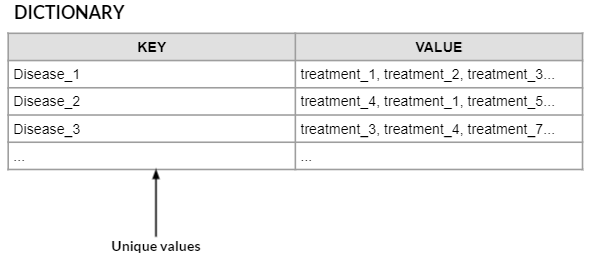

In [47]:
# Extracting a dictionary of all the predicted diseases from our test data and the corresponding treatments.
# Assumption: For each identified disease, one of the treatments is in the same sentence as the disease exists.
disease_treatment = {}            # Initializing an empty dictionary
for i in range(len(Y_pred)):
    cnt_disease = 0           # Count of number of diseases mentioned in the sentence
    cnt_treatment = 0         # Count of the number of treatments mentioned in the sentence
    diseases = [""]           # Initializing a blank list of diseases for current sentence.
    treatment = [""]          # Initializing a blank list of treatments for current sentence.
    length = len(Y_pred[i])   # Length of current sentence.
    for j in range(length):
        if (Y_pred[i][j] == 'D'):                                                     # Checking for label indicating disease for current word ('D')
            diseases[cnt_disease] += (X_test[i][j][0].split('=')[1] + " ")            # Adding word to diseases list.
            if j < length - 1:
                if (Y_pred[i][j+1] != 'D'):                                           # Check for name of disease extending over multiple words.
                    # If next word does not have label 'D', then truncate the space added at the end of the last word.
                    diseases[cnt_disease] = diseases[cnt_disease][:-1]
                    cnt_disease += 1
                    diseases.append("")                                               # Adding a placeholder for the next disease in the current sentence.
            else:
                diseases[cnt_disease] = diseases[cnt_disease][:-1]
                cnt_disease += 1
                diseases.append("")

        if (Y_pred[i][j] == 'T'):                                                     # Checking for label indicating treatment for current word ('T')
            treatment[cnt_treatment] += (X_test[i][j][0].split('=')[1] + " ") # Adding word to corresponding treatment list.
            if j < length - 1:
                if (Y_pred[i][j+1] != 'T'):                                           # Check for name of treatment extending over multiple words.
                    # If next word does not have label 'T', then truncate the space added at the end of the last word.
                    treatment[cnt_treatment] = treatment[cnt_treatment][:-1]
                    cnt_treatment += 1
                    treatment.append("")                                              # Adding a placeholder for the next treatment in the current sentence.
            else:
                treatment[cnt_treatment] = treatment[cnt_treatment][:-1]
                cnt_treatment += 1
                treatment.append("")

    diseases.pop(-1)    # Getting rid of the last empty placeholder in diseases list
    treatment.pop(-1)   # Getting rid of the last empty placeholder in treatments list

    # To our dictionary, add or append treatments to the diseases identified from the current sentence, if any.
    if len(diseases) > 0:       # Checking if any diseases have been identified for the current sentence.
        for disease in diseases:
            if disease in disease_treatment.keys():
                # Extend treatment list if other treatments for the particular disease already exist
                disease_treatment[disease].extend(treatment)
            else:
                # Creating list of treatments for particular disease if it doesn not exist already.
                disease_treatment[disease] = treatment

In [48]:
# Displaying dictionary of extracted diseases and potential treatments.
disease_treatment

{'gestational diabetes cases': [],
 'nonimmune hydrops fetalis': ['trisomy'],
 'preeclampsia': [],
 'severe preeclampsia': [],
 'asymmetric double hemiplegia': [],
 'reversible nonimmune hydrops fetalis': [],
 'breast and/or ovarian cancer': [],
 'breast cancer': ['hormone replacement therapy',
  'undergone subcutaneous mastectomy'],
 'ovarian cancer': ['hormone replacement therapy',
  'undergone subcutaneous mastectomy'],
 'prostate cancer': ['radical prostatectomy and iodine 125 interstitial radiotherapy'],
 'mutated prostate cancer': ['radical prostatectomy and iodine 125 interstitial radiotherapy'],
 'hereditary prostate cancer': [],
 'multiple sclerosis ( ms )': [],
 'hereditary retinoblastoma': ['radiotherapy'],
 'epilepsy': ['methylphenidate'],
 'unstable angina or non-q-wave myocardial infarction': ['roxithromycin'],
 'coronary-artery disease': ['antichlamydial antibiotics'],
 'early-stage cervical carcinoma': [],
 'colon tumors': [],
 'advanced disease': [],
 'cerebral palsy':

In [50]:
# Obtaining a cleaned version of our "disease_treatment" dictionary
cleaned_dict = {}
for key in disease_treatment.keys():
    if disease_treatment[key] != []:
        cleaned_dict[key] = disease_treatment[key]
cleaned_dict

{'nonimmune hydrops fetalis': ['trisomy'],
 'breast cancer': ['hormone replacement therapy',
  'undergone subcutaneous mastectomy'],
 'ovarian cancer': ['hormone replacement therapy',
  'undergone subcutaneous mastectomy'],
 'prostate cancer': ['radical prostatectomy and iodine 125 interstitial radiotherapy'],
 'mutated prostate cancer': ['radical prostatectomy and iodine 125 interstitial radiotherapy'],
 'hereditary retinoblastoma': ['radiotherapy'],
 'epilepsy': ['methylphenidate'],
 'unstable angina or non-q-wave myocardial infarction': ['roxithromycin'],
 'coronary-artery disease': ['antichlamydial antibiotics'],
 'cerebral palsy': ['hyperbaric oxygen therapy'],
 'primary pulmonary hypertension ( pph )': ['fenfluramines'],
 'cellulitis': ['g-csf therapy', 'intravenous antibiotic treatment'],
 'foot infection': ['g-csf treatment'],
 "early parkinson 's disease": ['ropinirole monotherapy'],
 'sore throat': ['antibiotics'],
 'female stress urinary incontinence': ['surgical treatment']

In [51]:
# Converting dictionary to a dataframe
cleaned_df = pd.DataFrame({"Disease":cleaned_dict.keys(),"Treatments":cleaned_dict.values()})
cleaned_df.head()

,Disease,Treatments
0,nonimmune hydrops fetalis,[trisomy]
1,breast cancer,"[hormone replacement therapy, undergone subcut..."
2,ovarian cancer,"[hormone replacement therapy, undergone subcut..."
3,prostate cancer,[radical prostatectomy and iodine 125 intersti...
4,mutated prostate cancer,[radical prostatectomy and iodine 125 intersti...


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [52]:
search_item = 'hereditary retinoblastoma'
treatments = cleaned_dict[search_item]
print("Treatments for '{0}' is/are ".format(search_item), end = "")
for i in range(len(treatments)-1):
    print("'{}'".format(treatments[i]),",", end="")
print("'{}'".format(treatments[-1]))

Treatments for 'hereditary retinoblastoma' is/are 'radiotherapy'
